In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)


####1- previous pakage loaded

####2- Outline of the assignment
#####Convolution functions, including:
-Zero Padding
-Convolve window
-Convolution forward
-Convolution backward (optional)

Pooling functions, including:
-Pooling forward
-Create mask
-Distribute value
-Pooling backward (optional)

####3- Zero padding exercise
###### the shape of X is m * n_H * n_W * channel

In [2]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=
                   0)
    return X_pad

('x.shape =', (4, 3, 3, 2))
('x_pad.shape =', (4, 7, 7, 2))
('x[1, 1] =', array([[ 0.90085595, -0.68372786],
       [-0.12289023, -0.93576943],
       [-0.26788808,  0.53035547]]))
('x_pad[1, 1] =', array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]]))


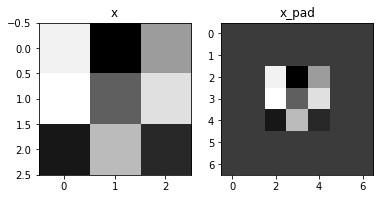

In [9]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_pad[1, 1] =", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

#####3.2- Single step of convolution
* take an input volume
* apply a filter in every position
* output another vlolume(usually of different size)

In [10]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W) +b
    z = np.sum(s)
    return z

In [17]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
w= np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
z = conv_single_step(a_slice_prev, w, b)
print("Z= ", z)

('Z= ', -23.160212202520778)


#####3.3- Convolutional Neural Network-Forward pass

In [12]:
def conv_forward(A_prev, W, b, hparameters):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    n_H = int((n_H_prev-f+2*pad)/stride+1)
    n_W = int((n_W_prev-f+2*pad)/stride+1)
    Z = np.zeros((m, n_H, n_W, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f 
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[..., c], b[..., c])
        
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)
    return Z, cache
                       
       
   
    

In [13]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.rand(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", Z.shape)
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])


("Z's mean =", (10, 7, 7, 8))
('cache_conv[0][1][2][3] =', array([-0.20075807,  0.18656139,  0.41005165]))


#####Finally, CONV layer should also contain an activation, in which case we would add the following line of code:

* Convolve the window to get back one output neuron
- Z[i, h, w, c] = ...
* Apply activation
- [i, h, w, c] = activation(Z[i, h, w, c])

In [14]:
####4 POOLING Layer
#####4-1 forward pooling

In [18]:
def pool_forward(A_prev, hparameters, mode = 'max'):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    n_H = int((n_H_prev - f)/stride + 1)
    n_W = int((n_W_prev - f)/stride + 1)
    n_C = n_C_prev 
    A = np.zeros((m, n_H, n_W, n_C))
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + stride
                    horiz_start = w * stride
                    horiz_end = vert_start + stride
                    
                    a_slice_prev = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_slice_prev)
                    if mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
    cache = (A_prev, hparameters)
    assert (A.shape == (m, n_H, n_W, n_C))
    return A, cache

In [20]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride": 1, "f": 4}
A, cache = pool_forward(A_prev, hparameters, mode='max')
print("mode = max")
print("A =", A,A.shape)
print()
A2, cache2 = pool_forward(A_prev, hparameters, mode="average")
print("mode = average")
print("A =", A2, A2.shape)
print()


mode = max
('A =', array([[[[ 1.62434536, -0.61175641, -0.52817175]]],


       [[[ 0.12015895,  0.61720311,  0.30017032]]]]), (2, 1, 1, 3))
()
mode = average
('A =', array([[[[ 1.62434536, -0.61175641, -0.52817175]]],


       [[[ 0.12015895,  0.61720311,  0.30017032]]]]), (2, 1, 1, 3))
()


#####5- Backpropagation in CNN

In [21]:
def conv_backward(dZ, cache):
    (A_prev, W, b, hparameters) = cache
    (m, n_W_prev, n_H_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    (m, n_H, n_W, n_C) = dZ.shape
    dA_prev = np.zeros((n_W_prev, n_H_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
                    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db
